In [ ]:
pwd


'/content'

In [ ]:
import tensorflow as tf
from vit import ViTClassfier
from utils import plot_grid_ds, AttrDict, BalancedSparseCategoricalAccuracy

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


path = Path("/content/data/Training")
img_as_jpg = list(path.glob(r"*/*.jpg"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],img_as_jpg))
glioma = file_count.count('glioma_tumor')
meningioma = file_count.count('meningioma_tumor')
no_tum = file_count.count('no_tumor')
pituitary = file_count.count('pituitary_tumor')

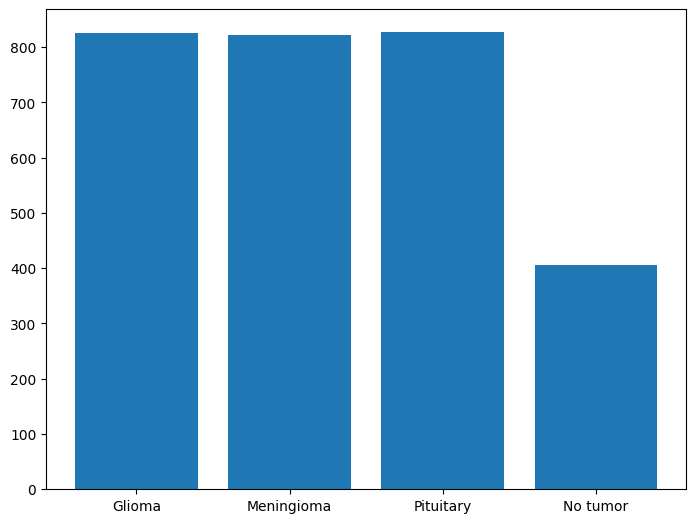

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Glioma','Meningioma', 'Pituitary', 'No tumor']
count_train = [glioma, meningioma, pituitary, no_tum]
ax.bar(labels, count_train)
plt.show()

In [ ]:
train = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

(2880, 2)


In [ ]:
train = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

(2880, 2)


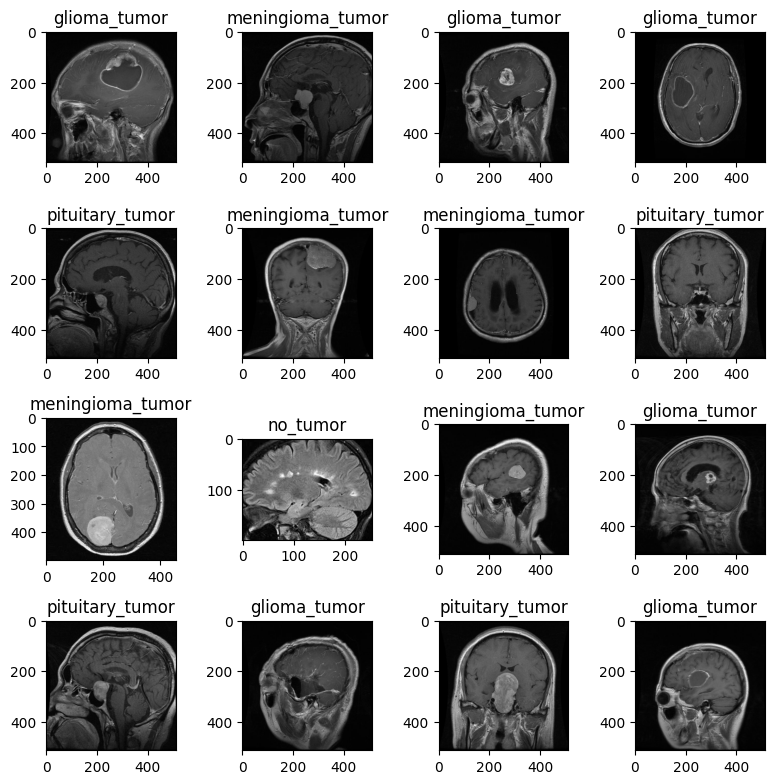

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1):
    ax.imshow(plt.imread(train["image"][counter]))
    ax.set_title(train["type"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter+1

In [ ]:
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=4,
    batch_size=64,
)

ds = tf.keras.preprocessing.image_dataset_from_directory("/content/data/Training", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
train_split = round(0.8 * ds.cardinality().numpy())
train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

Found 2880 files belonging to 4 classes.


In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

In [ ]:
model.fit(train_ds, epochs=20, validation_data=validation_ds)

Epoch 1/20
36/36 [==============================] - 105s 3s/step - loss: 9.7348 - accuracy: 0.4722 - balanced_sparse_categorical_accuracy: 0.4558 - val_loss: 0.8072 - val_accuracy: 0.6701 - val_balanced_sparse_categorical_accuracy: 0.6033
Epoch 2/20
36/36 [==============================] - 96s 3s/step - loss: 0.6993 - accuracy: 0.7266 - balanced_sparse_categorical_accuracy: 0.7127 - val_loss: 0.5286 - val_accuracy: 0.7812 - val_balanced_sparse_categorical_accuracy: 0.7685
Epoch 3/20
36/36 [==============================] - 106s 3s/step - loss: 0.5302 - accuracy: 0.7947 - balanced_sparse_categorical_accuracy: 0.7811 - val_loss: 0.5819 - val_accuracy: 0.8212 - val_balanced_sparse_categorical_accuracy: 0.8429
Epoch 4/20
36/36 [==============================] - 90s 2s/step - loss: 0.4598 - accuracy: 0.8229 - balanced_sparse_categorical_accuracy: 0.8293 - val_loss: 0.3944 - val_accuracy: 0.8507 - val_balanced_sparse_categorical_accuracy: 0.8370
Epoch 5/20
36/36 [============================

1/1 [==============================] - 1s 597ms/step


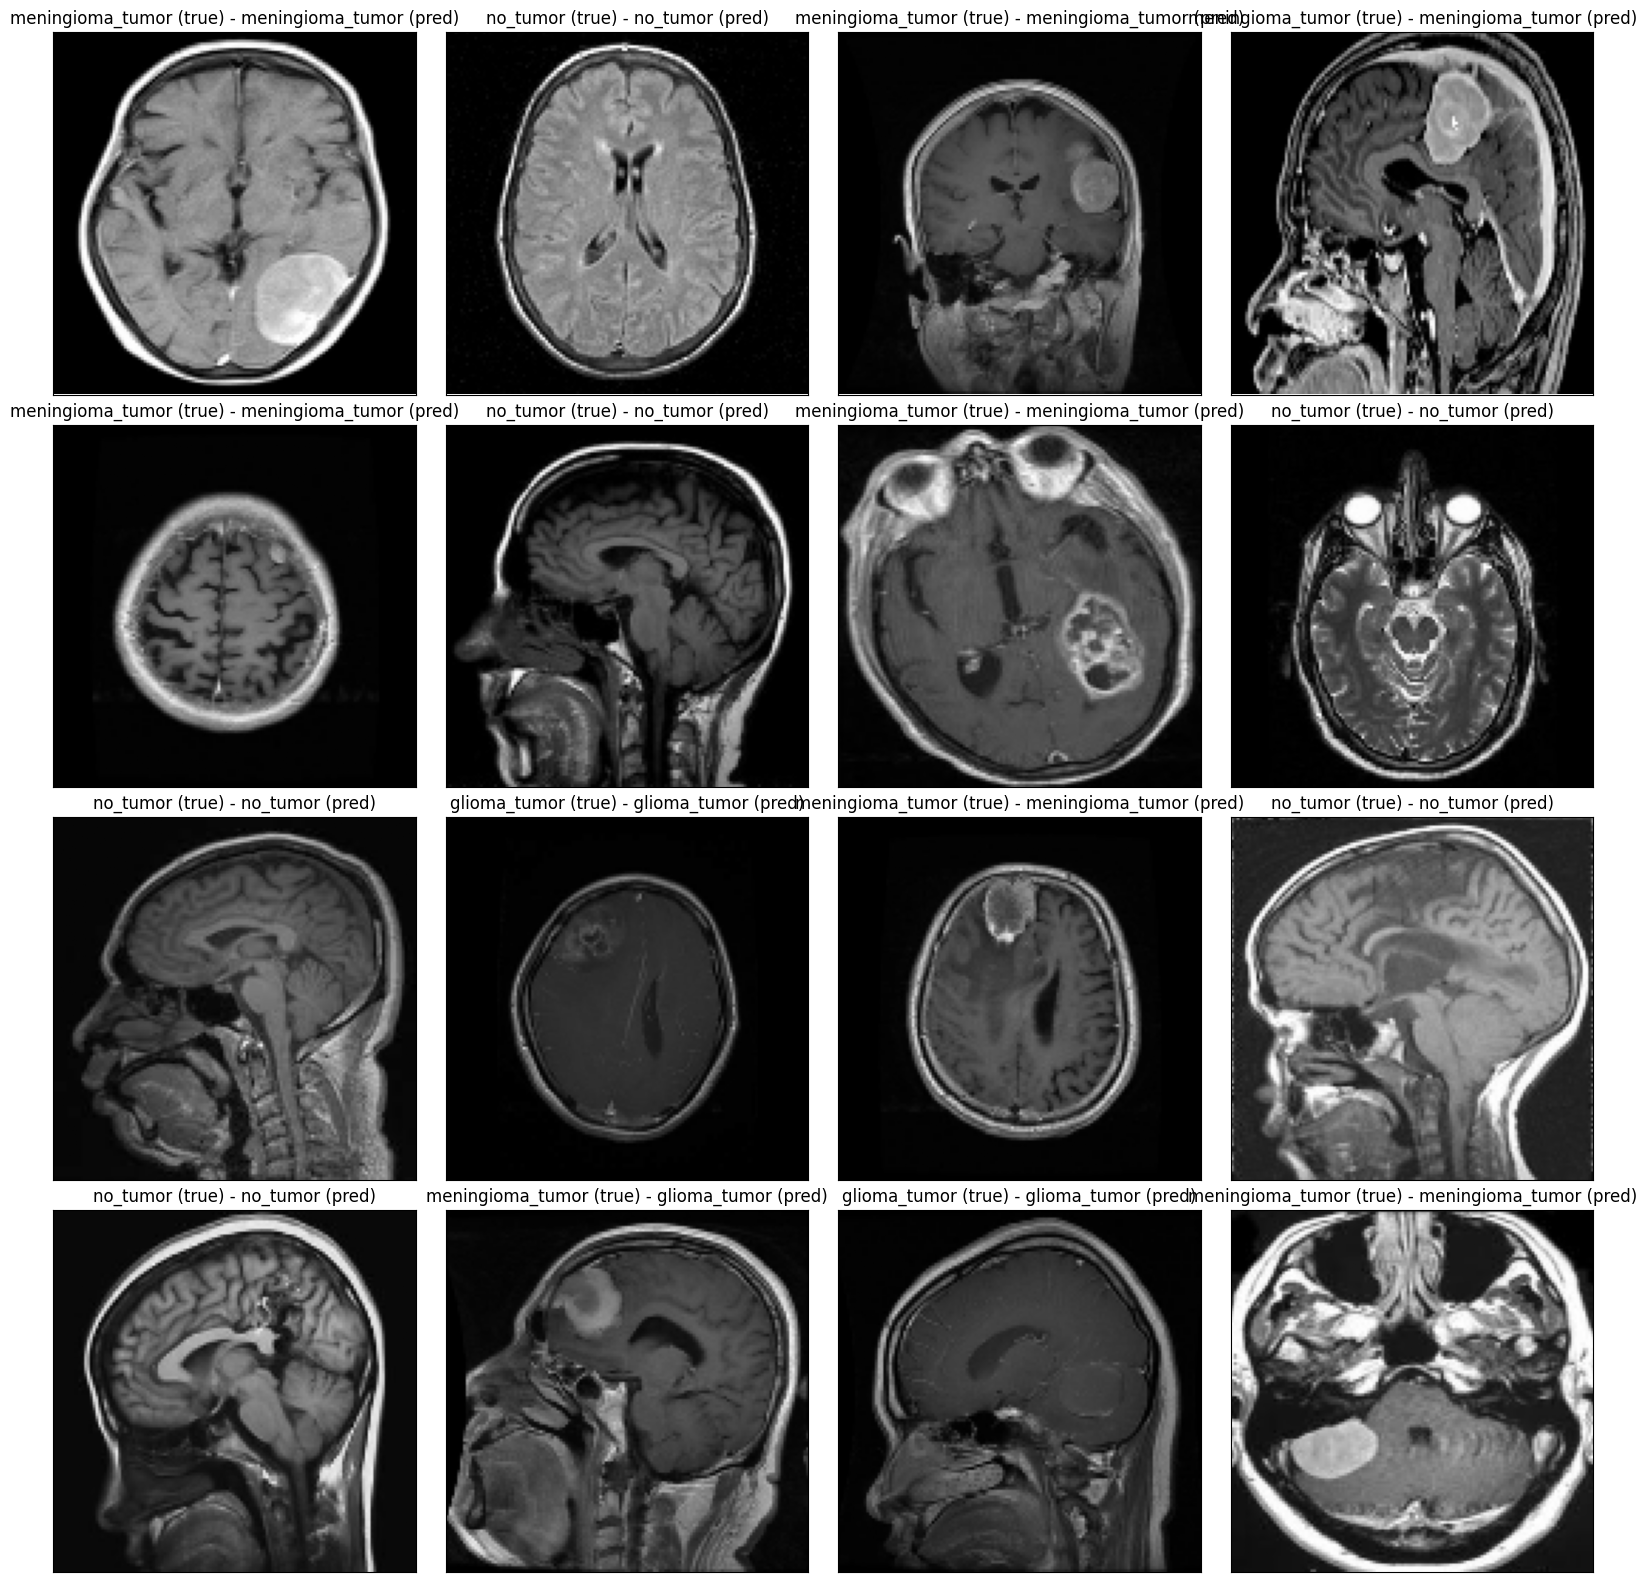

In [ ]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")

Final accuracy on validation set : 0.963


In [ ]:
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=4,
    batch_size=64,
)

ds = tf.keras.preprocessing.image_dataset_from_directory("/content/data/Training", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
ds1 = tf.keras.preprocessing.image_dataset_from_directory("/content/data/Testing", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
train_split = round(0.8 * ds.cardinality().numpy())
train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
validation_ds = ds1; validation_ds.class_names = ds1.class_names

Found 2880 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

In [ ]:
model.fit(train_ds, epochs=20, validation_data=validation_ds)

Epoch 1/20
36/36 [==============================] - 108s 3s/step - loss: 6.7581 - accuracy: 0.4748 - balanced_sparse_categorical_accuracy: 0.4671 - val_loss: 1.5717 - val_accuracy: 0.4036 - val_balanced_sparse_categorical_accuracy: 0.4340
Epoch 2/20
36/36 [==============================] - 89s 2s/step - loss: 0.6132 - accuracy: 0.7708 - balanced_sparse_categorical_accuracy: 0.7603 - val_loss: 2.2321 - val_accuracy: 0.3883 - val_balanced_sparse_categorical_accuracy: 0.4344
Epoch 3/20
36/36 [==============================] - 89s 2s/step - loss: 0.4774 - accuracy: 0.8086 - balanced_sparse_categorical_accuracy: 0.8110 - val_loss: 2.5099 - val_accuracy: 0.4036 - val_balanced_sparse_categorical_accuracy: 0.4405
Epoch 4/20
36/36 [==============================] - 89s 2s/step - loss: 0.3969 - accuracy: 0.8420 - balanced_sparse_categorical_accuracy: 0.8505 - val_loss: 2.4229 - val_accuracy: 0.4797 - val_balanced_sparse_categorical_accuracy: 0.4633
Epoch 5/20
36/36 [=============================

1/1 [==============================] - 1s 554ms/step


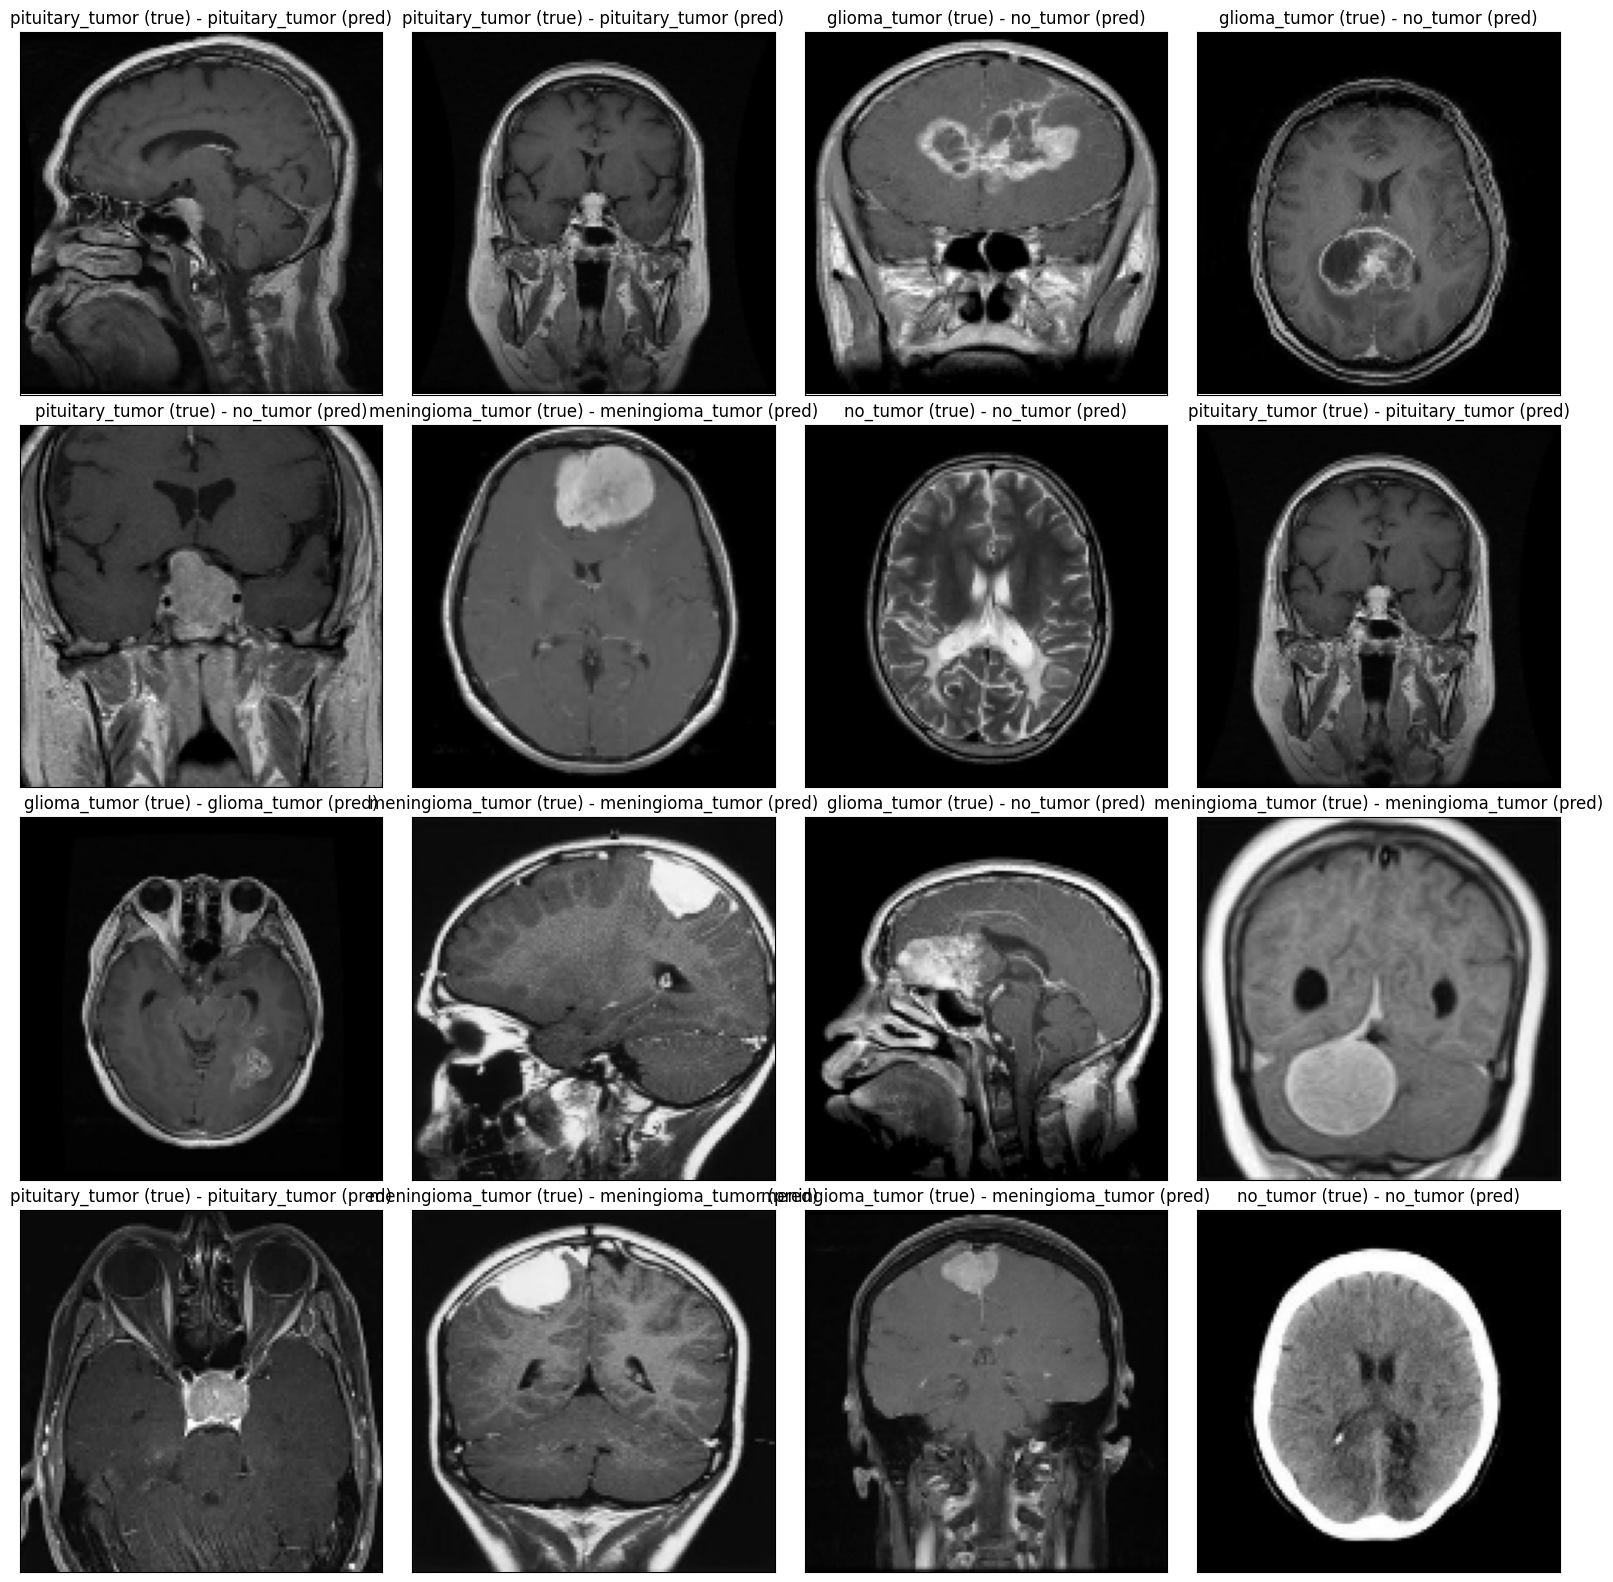

In [ ]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

array([[ 18,  13,  61,   8],
       [  0, 109,   6,   0],
       [  0,   0, 105,   0],
       [  0,   7,   8,  59]])

In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")

Final accuracy on validation set : 0.731


In [ ]:
model.save("models/ViT_on_20_epochs.model")

In [ ]:

!rm -rf Vit_on_10_epochs.model

In [ ]:
%cd content


/content
